<a href="https://colab.research.google.com/github/maperezp/Proyecto-DL-Grupo4/blob/main/model/Grupo04_proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto Deep Learning - Grupo 4**
#### **Título: Modelo para la predicción de estadios tempranos de fibrosis hepática en pacientes a partir de imágenes de ecografía**
#### **Integrantes:**
* María Alejandra Pérez Petro
* David Esteban Fajardo Torres
* Cristian Daniel Borda Bastidas
* Lizeth Viviana Perdomo Castañeda

### **Tabla de Contenido**

- [Configuración ambiente](#scrollTo=Y0uG9hYqq1VG)<br>
- [Preparación de Imagenes](#scrollTo=SSAeSXEt5Uv-)<br>
- [Modelamiento](#scrollTo=n-VQFFaovrv8)<br>
- [Modelo 1: Red Neuronal Convolucional (CNN)](#scrollTo=9wvSd-irWHna)<br>
- [Modelo 2: VGG 16 con Fine Tuning](#scrollTo=8gACm1N_qMKI)<br>
- [Modelo 3: Resnet 50 con Fine tuning](#scrollTo=c0aJBAQGGS3K)<br>
- [Modelo para despliegue](#scrollTo=Mc1UZ3iSFB8T)<br>

# **Configuración ambiente**


### Kaggle

In [ ]:
# Instalar Kaggle Library
!pip install kaggle

# Cargar kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"key":"mariaperezpetro","username":"1da55f00621264b50b6666818de09c9d"}'}

In [ ]:
# Crear directorio para la configuración de Kaggle
!mkdir -p ~/.kaggle

# Mover kaggle.json al directorio creado anteriormente
!mv kaggle.json ~/.kaggle/

# Setear permisos
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Descargar el dataset a usar desde Kaggle
!kaggle datasets download -d vibhingupta028/liver-histopathology-fibrosis-ultrasound-images
# Desempaquetar Dataset
!unzip liver-histopathology-fibrosis-ultrasound-images.zip -d ./liver_dataset

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7378.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a738.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7384.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7405.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a741.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7410.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7412.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7415.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7425.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7431.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7435.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7446.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7448.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7460.jpg  
  inflating: ./liver_dataset/Dataset/Dataset/F0/a7464.jpg  
  inflating: ./liver_dataset/Datase

## Librerias

In [ ]:
#Importar librerias necesarias
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import cohen_kappa_score


import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model


from sklearn.utils import class_weight

from tensorflow.keras.models import load_model

## Funciones globales

In [ ]:
def plot_clasification_examples(random_indices):
  # Set up the plot
  plt.figure(figsize=(16, 10))

  # Loop over the selected random indices to plot the images
  for i, idx in enumerate(random_indices):
      plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
      img = X_test[idx].squeeze()  # Remove the channel dimension if it's there
      actual_label = y_test[idx]
      predicted_label = y_pred_labels[idx]

      # Plot the image
      plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
      plt.axis('off')  # Turn off axes

      # Set the title with the actual and predicted labels
      plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")

  plt.tight_layout()

# **Preparación de Imagenes**

## Cargar todas las imagenes
Guarda las rutas de todas las imagenes en un dataframe con path y label

In [ ]:
# Definir la ubicación de las imagenes del dataset
image_folder = './liver_dataset/Dataset/Dataset/'

# Crear la lista para los estados de la Fibrosis a analizar
class_labels = ['F0', 'F1', 'F2', 'F3', 'F4']

# Listas vacias para almacenar ubicación y etiquetas de imagenes
image_paths = []
labels = []

for label in class_labels:
    class_folder = os.path.join(image_folder, label)
    for img_name in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img_name))
        labels.append(label)

# Creación Dataframe
data = pd.DataFrame({'Image_Path': image_paths, 'Label': labels})



In [ ]:
train_data

Image_Path Label
6184      ./liver_dataset/Dataset/Dataset/F4/f36.jpg    F4
5537    ./liver_dataset/Dataset/Dataset/F4/O4830.jpg    F4
4430   ./liver_dataset/Dataset/Dataset/F3/ct11-7.png    F3
1460    ./liver_dataset/Dataset/Dataset/F0/a4902.jpg    F0
3248   ./liver_dataset/Dataset/Dataset/F2/ct4-30.png    F2
...                                              ...   ...
1752    ./liver_dataset/Dataset/Dataset/F0/a3404.jpg    F0
4509  ./liver_dataset/Dataset/Dataset/F3/ct12-36.png    F3
4138    ./liver_dataset/Dataset/Dataset/F3/L9570.jpg    F3
2617    ./liver_dataset/Dataset/Dataset/F1/m4032.jpg    F1
3028    ./liver_dataset/Dataset/Dataset/F2/K5225.jpg    F2

[4046 rows x 2 columns]

In [ ]:
# Ubicación imagen ejemplo
image_path = "./liver_dataset/Dataset/Dataset/F1/h2767.jpg"

# Abrir la imagen
image = Image.open(image_path)

#Convertir la imagen a un array
image_array = np.array(image)

# obtención de dimensiones
height, width = image_array.shape[:2]  # alto y ancho
channels = 1 if len(image_array.shape) == 2 else image_array.shape[2]  # validar escala de grises

print(f"Dimensiones Imagen: {width}x{height}")
print(f"Numero de canales: {channels}")


Dimensiones Imagen: 640x480
Numero de canales: 1


In [ ]:
images_examples = train_data.groupby("Label")["Image_Path"].min().reset_index()
plt.figure(figsize=(15, 8))
for i in range (0, len(images_examples)):
  path= images_examples["Image_Path"].iloc[i]
  label = images_examples["Label"].iloc[i]
  img = Image.open(path)
  plt.subplot(2,3,i+1)
  plt.imshow(img, cmap = "grey")
  plt.title(label)
  plt.axis('off')
plt.show()

## Separación de los datos

In [ ]:
# Separar conjuntos de training y testing
train_data, test_data = train_test_split(data, test_size=0.2, stratify=data['Label'], random_state=42, shuffle = True)

# Ahora dividir el conjunto de entrenamiento: en entrenamiento y validación
train_data, val_data = train_test_split(train_data, test_size=0.2, stratify=train_data['Label'], random_state=42, shuffle = True)

# Validar la separación de entrenamiento y testing
print(f"Total imagenes: {len(data)}")
print(f"Conjunto de training: {len(train_data)} imagenes")
print(f"Conjunto de testing: {len(test_data)} imagenes")
print(f"Conjunto de validación: {len(val_data)} imagenes")



In [ ]:
# Graficar como quedo la distribución de clases para training y testing
def plot_class_distribution(data, title):
    class_counts = data['Label'].value_counts().reset_index()
    class_counts.columns = ['Class', 'Count']
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Class', y='Count', data=class_counts)
    plt.title(title)
    plt.xlabel('Clase')
    plt.ylabel('Count')
    plt.show()

plot_class_distribution(train_data, "Distribución de las clases en el set de training")
plot_class_distribution(test_data, "Distribución de las clases en el set de testing")

## Preprocesamiento imagenes

In [ ]:
# Carga de imagenes y etiquetas
def load_images_and_labels_from_dataframe(dataframe, image_size=(224, 224)):
    images = []
    labels = []
    class_names = sorted(dataframe['Label'].unique())
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

    for _, row in dataframe.iterrows():
        img_path = row['Image_Path']
        label = row['Label']
        img = Image.open(img_path)

        # Validar si la imagen esta en escala de grises, si no convertir a RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        img = img.resize(image_size)
        img_array = np.array(img)

        # Agregar imagen y su etiqueta
        images.append(img_array)
        labels.append(class_indices[label])

    return np.array(images), np.array(labels), class_indices

# Carga de imagenes y etiquetas
image_size = (224, 224)  # reconfigurar el tamaño de las imagenes a 224x224
X_train, y_train, class_indices = load_images_and_labels_from_dataframe(train_data, image_size=image_size)
X_val, y_val, _ = load_images_and_labels_from_dataframe(val_data, image_size=image_size)
X_test, y_test, _ = load_images_and_labels_from_dataframe(test_data, image_size=image_size)

# Normalización de imagenes
X_train = X_train.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Número de clases e indices respectivos
num_classes = len(class_indices)
print(f"Clases: {class_indices}")
print(f"Número de clases: {num_classes}")


Clases: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Número de clases: 5


In [ ]:
# Calcular los pesos inversos
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train), # y_train contiene las etiquetas numéricas (0, 1, 2, 3, 4)
    y=y_train
)

# Convertir el array a un diccionario (formato que espera Keras)
class_weights_dict = dict(enumerate(class_weights))

print("Pesos de Clase Calculados (Clase: Peso):")
print(class_weights_dict)

#Los pesos de F1, F2 y F3 seran mayores que F0 y F4.

Pesos de Clase Calculados (Clase: Peso):
{0: np.float64(0.5980783444198078), 1: np.float64(1.4686025408348458), 2: np.float64(1.5960552268244577), 3: np.float64(1.473952641165756), 4: np.float64(0.7451197053406998)}


In [ ]:

print("X train:", X_train.shape)
print("y train:", y_train.shape)


X train: (4046, 224, 224, 3)
y train: (4046,)


## Aumentación de imagenes

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
train_aumented = datagen.flow(X_train, y_train, batch_size=5, shuffle=True)

# **Modelamiento**

## Modelo 1: Red Neuronal Convolucional (CNN)

### Entrenamiento

In [ ]:
# Define el valor del factor de regularización
l2_factor = 0.001

model = Sequential([
    Conv2D(40, kernel_size=(2, 2), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(40, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(40, kernel_size=(4, 4), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(l2_factor)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Conv2D(70, kernel_size=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(70, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    Conv2D(70, kernel_size=(4, 4), activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_factor)),
    Dropout(0.5),
    Dense(5, activation='softmax')
])

# Compilación del modelo
model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 223, 223, 40)   │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 221, 221, 40)   │        14,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 218, 218, 40)   │        25,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 109, 109, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 109, 109, 40)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 108, 108, 70)   │        11,270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 106, 106, 70)   │        44,170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 103, 103, 70)   │        78,470 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 51, 51, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 51, 51, 70)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 182070)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    23,305,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,480,243 (89.57 MB)

 Trainable params: 23,480,243 (89.57 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history = model.fit(train_aumented,
                    steps_per_epoch=len(X_train) // 5,
                    epochs=200,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

Epoch 1/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 54s 59ms/step - accuracy: 0.3962 - loss: 1.6620 - val_accuracy: 0.4417 - val_loss: 1.2302
Epoch 2/200
  1/809 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4000 - loss: 1.4723

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4000 - loss: 1.4723 - val_accuracy: 0.4447 - val_loss: 1.2228
Epoch 3/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4494 - loss: 1.2360 - val_accuracy: 0.4704 - val_loss: 1.1587
Epoch 4/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.0000e+00 - loss: 1.5165 - val_accuracy: 0.4684 - val_loss: 1.1598
Epoch 5/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4630 - loss: 1.2013 - val_accuracy: 0.4694 - val_loss: 1.1392
Epoch 6/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2000 - loss: 1.1124 - val_accuracy: 0.4694 - val_loss: 1.1390
Epoch 7/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.4662 - loss: 1.1765 - val_accuracy: 0.4595 - val_loss: 1.1361
Epoch 8/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6000 - loss: 0.9529 - val_accuracy: 0.4595 - val_loss: 1.1360
Epoch 9/200
809/809 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.4631 - loss: 1.1743 - val_accu

### Pérdida y Precisión

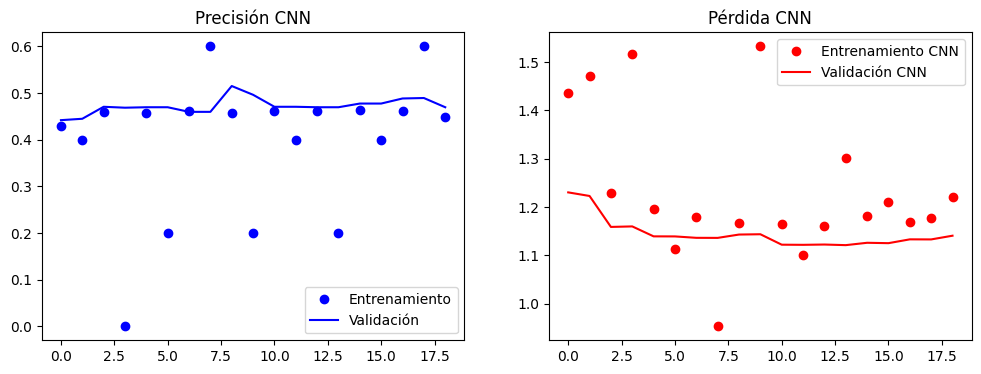

In [ ]:
acc_vgg = history.history['accuracy']
val_acc_vgg = history.history['val_accuracy']
loss_vgg = history.history['loss']
val_loss_vgg = history.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(acc_vgg, 'bo', label='Entrenamiento')
plt.plot(val_acc_vgg, 'b', label='Validación')
plt.title('Precisión CNN')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss_vgg, 'ro', label='Entrenamiento CNN')
plt.plot(val_loss_vgg, 'r', label='Validación CNN')
plt.title('Pérdida CNN')
plt.legend()

plt.show()

### Resultados (Training set)


In [ ]:
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred))

127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 58ms/step
              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1353
           1       0.00      0.00      0.00       551
           2       1.00      0.00      0.00       507
           3       0.30      1.00      0.46       549
           4       0.12      0.00      0.01      1086

    accuracy                           0.47      4046
   macro avg       0.41      0.40      0.25      4046
weighted avg       0.41      0.47      0.32      4046



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Resultados (Test set)

In [ ]:
y_pred = model.predict(X_test)
# Get the predicted class labels (for sparse categorical crossentropy, we use argmax)
y_pred_labels = np.argmax(y_pred, axis=1)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


In [ ]:


print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       423
           1       0.00      0.00      0.00       172
           2       1.00      0.01      0.01       159
           3       0.30      1.00      0.47       171
           4       0.00      0.00      0.00       340

    accuracy                           0.47      1265
   macro avg       0.38      0.40      0.25      1265
weighted avg       0.37      0.47      0.32      1265



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


#### Matriz de confusión

In [ ]:
#Generar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_labels)

#Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - CNN (Test Set)')
plt.show()

### Ejemplos de clasificación

In [ ]:
good_idx = np.where(y_pred_labels == y_test)[0]
bad_idx = np.where(y_pred_labels != y_test)[0]

print(f"Good predictions: {len(good_idx)}")
print(f"Bad predictions: {len(bad_idx)}")

num_examples = 10
example_good_idx = np.random.choice(good_idx, size=num_examples, replace=False)
example_bad_idx = np.random.choice(bad_idx, size=num_examples, replace=False)


Good predictions: 595
Bad predictions: 670


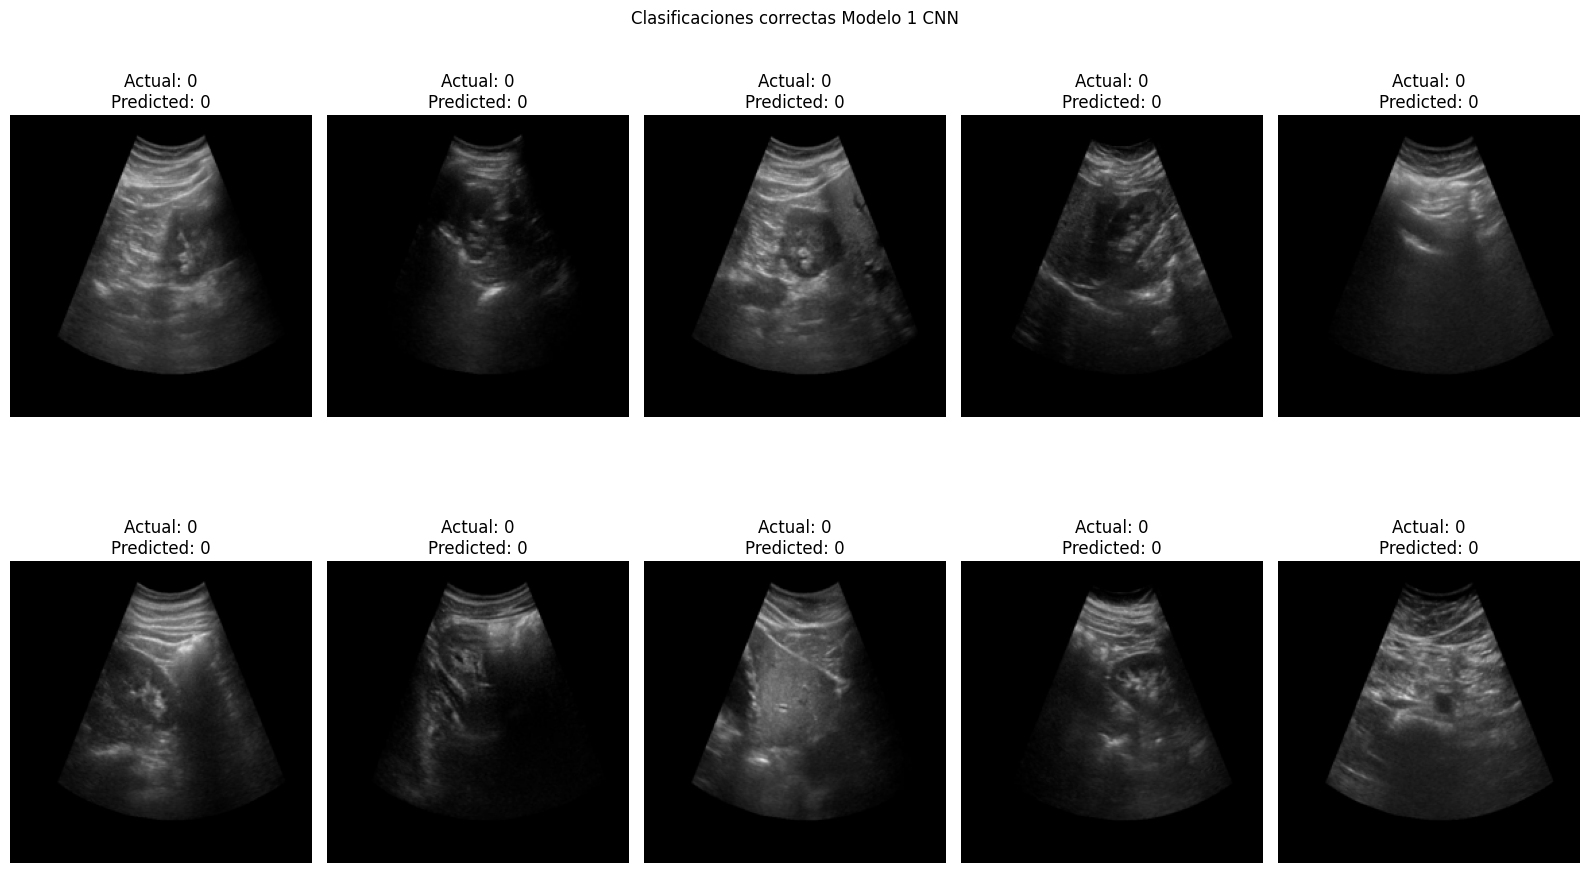

In [ ]:
plot_clasification_examples(example_good_idx)
plt.suptitle("Clasificaciones correctas Modelo 1 CNN")
plt.show()

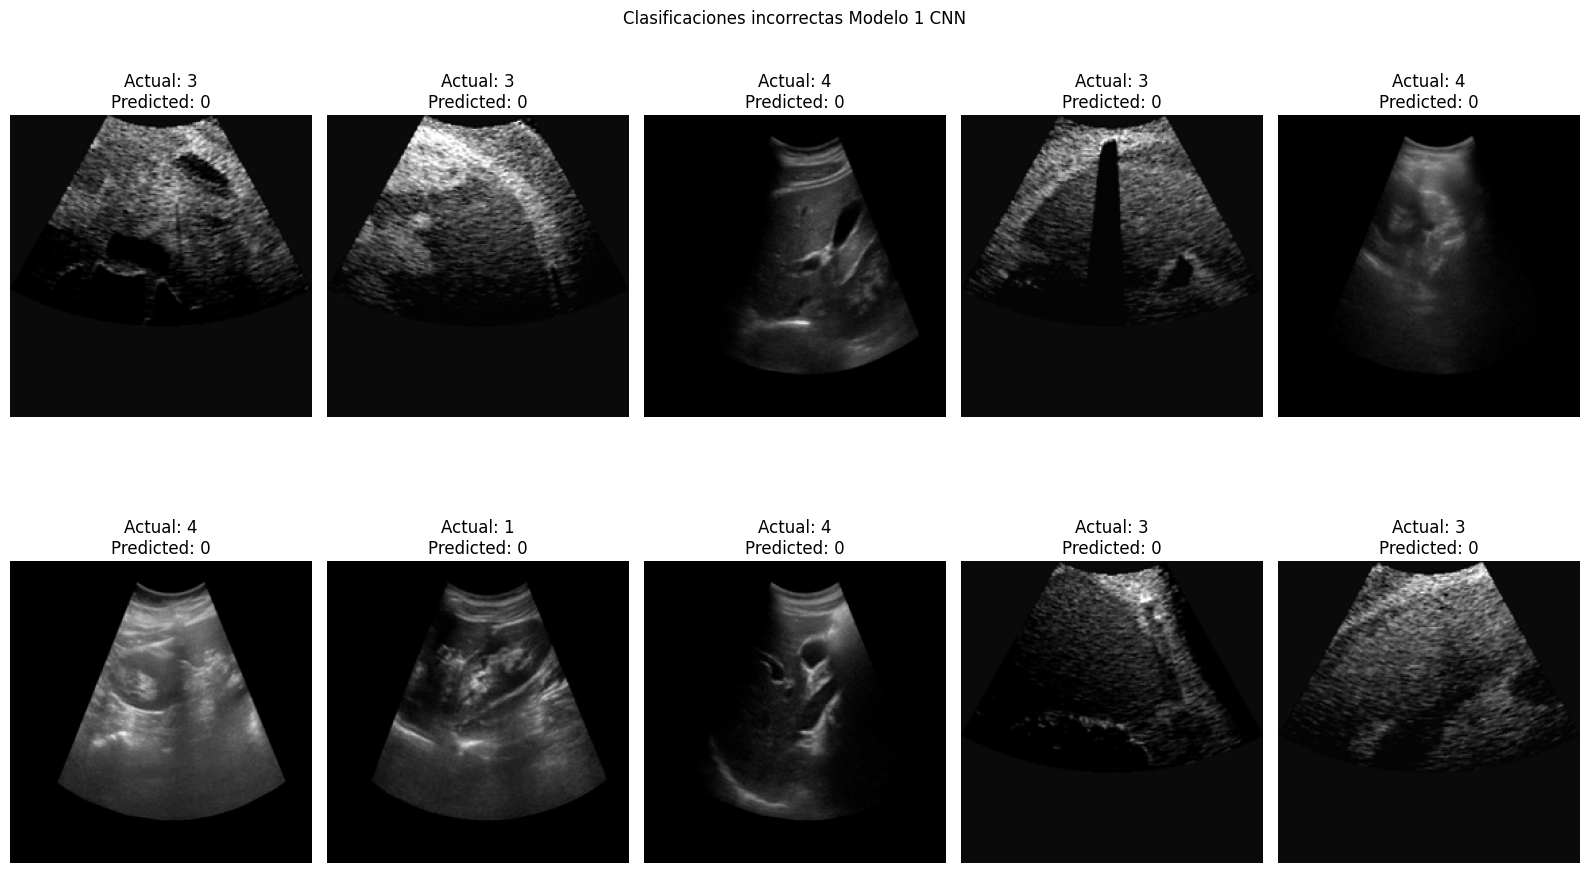

In [ ]:
plot_clasification_examples(example_bad_idx)
plt.suptitle("Clasificaciones incorrectas Modelo 1 CNN")
plt.show()

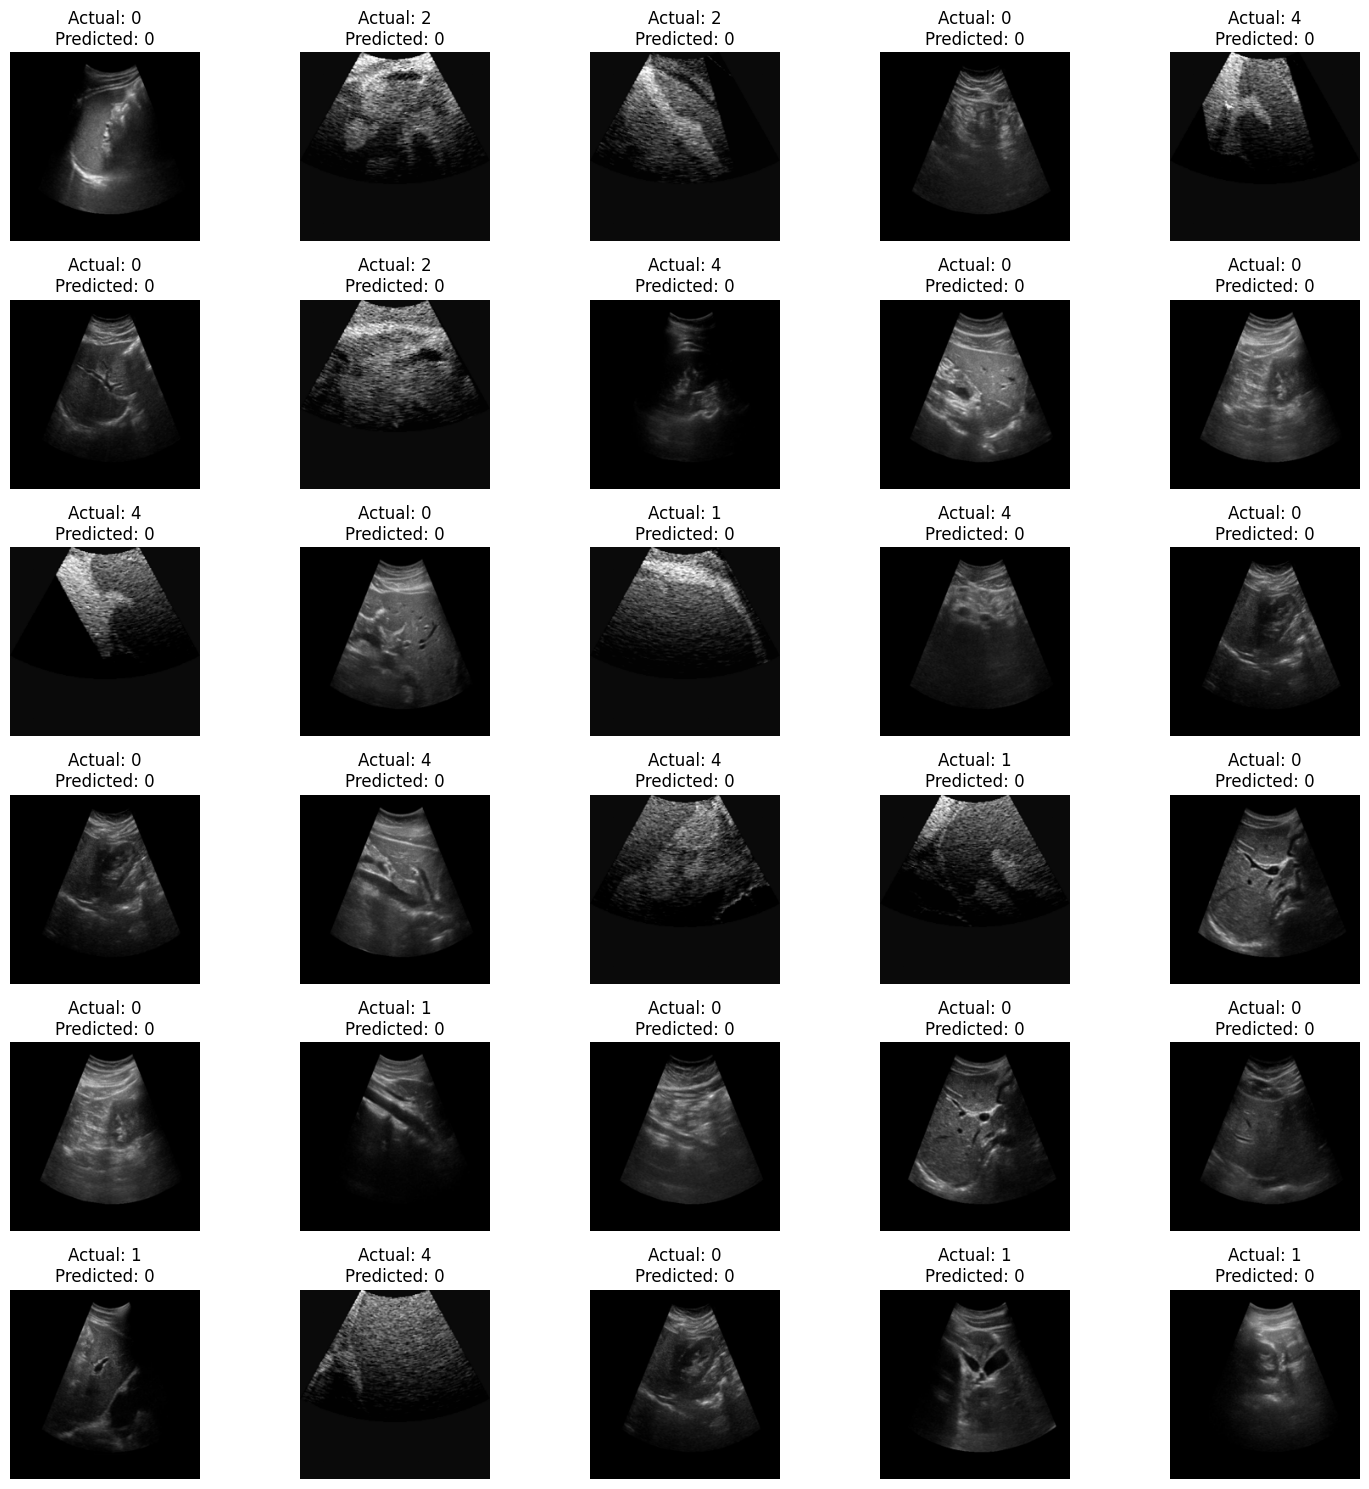

In [ ]:



# Randomly select 30 images and their corresponding labels
num_images = 30
random_indices = np.random.choice(X_test.shape[0], num_images, replace=False)



### Resultados del modelo CNN

* F0 y F3 (clases cominantes): Tienen un recall cercano al 1.00, lo que significa que el modelo está sobre-prediciendo estas dos clases. De hecho, el modelo solo está aprendiendo a distinguir entre 2 o 3 categorías de manera efectiva.

* F1, F2, F4 (clases críticas): El recall para estas clases es cercano a 0.00. Confirma que el modelo no ha aprendido a identificar la mayoría de los casos reales de fibrosis intermedia o avanzada.

* Accuracy global: Bajo, alrededor de 0.47

* Pérdida de entrenamiento (Puntos rojos): Es extremadamente ruidosa, saltando de 1.4 a 0.95 en cuestión de una o dos épocas.

* Precisión de entrenamiento (Puntos azules): Muestra picos y valles, lo que indica que el optimizador tiene dificultades para encontrar una dirección estable.

## Conclusión
La inestabilidad y el bajo rendimiento persisten. El problema fundamental no es de hiperparámetros, sino que la arquitectura CNN, entrenada desde cero, es demasiado compleja para ser entrenada con la cantidad de datos disponibles.



## ------------------------------------------------------------------------------

## Modelo 2: VGG 16 con Fine Tuning

### Definición arquitectura

In [ ]:
conv_base_vgg = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(224, 224, 3))

In [ ]:
# Congelar capas del modelo pre-entrenado
conv_base_vgg.trainable = False

# Descongerlar ultimas capas para fine tuning
for layer in conv_base_vgg.layers[-4:]:
    layer.trainable = True

print("Capas entrenables en VGG16:")
for layer in conv_base_vgg.layers:
    print(f"{layer.name}: {'Entrenable' if layer.trainable else 'No entrenable'}")

Capas entrenables en VGG16:
input_layer_4: No entrenable
block1_conv1: No entrenable
block1_conv2: No entrenable
block1_pool: No entrenable
block2_conv1: No entrenable
block2_conv2: No entrenable
block2_pool: No entrenable
block3_conv1: No entrenable
block3_conv2: No entrenable
block3_conv3: No entrenable
block3_pool: No entrenable
block4_conv1: No entrenable
block4_conv2: No entrenable
block4_conv3: No entrenable
block4_pool: No entrenable
block5_conv1: Entrenable
block5_conv2: Entrenable
block5_conv3: Entrenable
block5_pool: Entrenable


In [ ]:
model_vgg = models.Sequential()
model_vgg.add(conv_base_vgg)  # Añadir VGG16 como base
model_vgg.add(layers.Flatten())  # Aplanamiento de la salida convolucional
model_vgg.add(layers.Dense(128, activation='relu'))  # Capa densa con ReLU
model_vgg.add(layers.Dropout(0.3))  # Capa de Dropout para la regularizacion
model_vgg.add(layers.Dense(5, activation='softmax'))

In [ ]:

# Compilar el modelo con el optimizador RMSprop
model_vgg.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-5),  # Baja tasa de aprendizaje para el fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Imprimir el resumen del modelo para ver arquitectura
model_vgg.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,926,725 (68.39 MB)

 Trainable params: 10,291,461 (39.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

### Entrenamiento

In [ ]:
# Difiniendo el Callback Early Stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitorear accuracy
    patience=4,              # Detenerse despues de 4 epochs sin mejoras
    restore_best_weights=True  # Restaurar pesos del mejor modelo
)


In [ ]:
history_vgg = model_vgg.fit(
    X_train, y_train,
    epochs=50,
    batch_size=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.3569 - loss: 1.4687 - val_accuracy: 0.5791 - val_loss: 1.0648
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 484ms/step - accuracy: 0.5500 - loss: 1.0706 - val_accuracy: 0.5692 - val_loss: 0.9568
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.6017 - loss: 0.9604 - val_accuracy: 0.6581 - val_loss: 0.8608
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.6462 - loss: 0.8634 - val_accuracy: 0.6433 - val_loss: 0.8435
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 494ms/step - accuracy: 0.6814 - loss: 0.7934 - val_accuracy: 0.6966 - val_loss: 0.7258
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 491ms/step - accuracy: 0.7157 - loss: 0.7203 - val_accuracy: 0.7154 - val_loss: 0.6884
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 490ms/step - accuracy: 0.7257 - loss: 0.6880 - val_accuracy: 0.7431 - val_loss: 0.6325
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 487ms/step - accuracy: 0.7545 - loss: 0.6394 - val_accurac

### Pérdida y Precisión

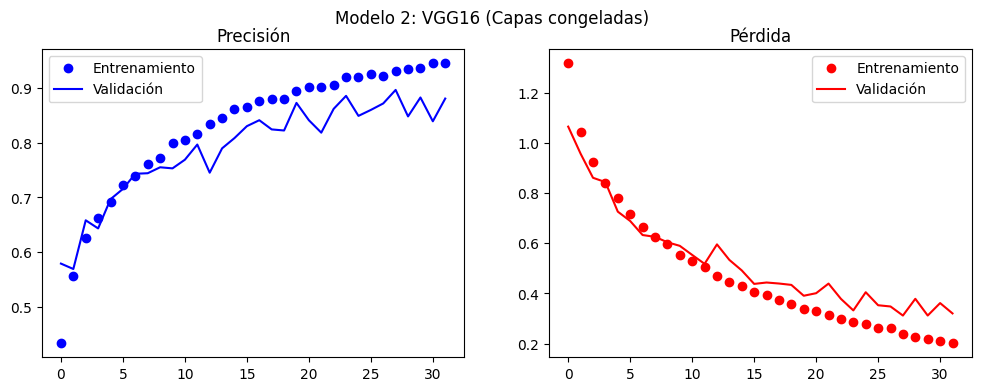

In [ ]:
acc_vgg = history_vgg.history['accuracy']
val_acc_vgg = history_vgg.history['val_accuracy']
loss_vgg = history_vgg.history['loss']
val_loss_vgg = history_vgg.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.suptitle("Modelo 2: VGG16 (Capas congeladas)")
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc_vgg, 'b', label="Validación")
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Entrenamiento')
plt.plot(epochs, val_loss_vgg, 'r', label='Validación')
plt.title('Pérdida')
plt.legend()

plt.show()

### Resultados (Training set)

In [ ]:
y_pred_train = model_vgg.predict(X_train)
y_pred_train = np.argmax(y_pred, axis=1)

print(classification_report(y_train, y_pred_train))

127/127 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1353
           1       0.93      0.85      0.89       551
           2       0.75      1.00      0.85       507
           3       0.98      0.80      0.88       549
           4       0.98      0.96      0.97      1086

    accuracy                           0.94      4046
   macro avg       0.93      0.92      0.92      4046
weighted avg       0.95      0.94      0.94      4046



### Resultados (testing set)

In [ ]:
y_pred = model_vgg.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels))

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       423
           1       0.88      0.77      0.82       172
           2       0.64      0.93      0.76       159
           3       0.94      0.71      0.81       171
           4       0.97      0.93      0.95       340

    accuracy                           0.90      1265
   macro avg       0.88      0.87      0.87      1265
weighted avg       0.92      0.90      0.91      1265



#### Matriz de confusión

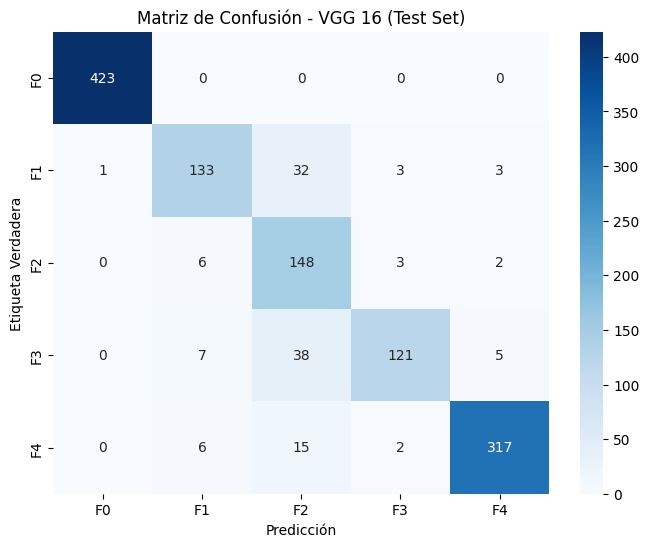

In [ ]:
#Generar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_labels)

#Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - VGG 16 (Test Set)')
plt.show()

### Ejemplos de clasificación

In [ ]:
good_idx = np.where(y_pred_labels == y_test)[0]
bad_idx = np.where(y_pred_labels != y_test)[0]

print(f"Good predictions: {len(good_idx)}")
print(f"Bad predictions: {len(bad_idx)}")

num_examples = 10
example_good_idx = np.random.choice(good_idx, size=num_examples, replace=False)
example_bad_idx = np.random.choice(bad_idx, size=num_examples, replace=False)

Good predictions: 1142
Bad predictions: 123


In [ ]:
plot_clasification_examples(example_good_idx)
plt.suptitle("Clasificaciones correctas Modelo 2 VGG 16")
plt.show()

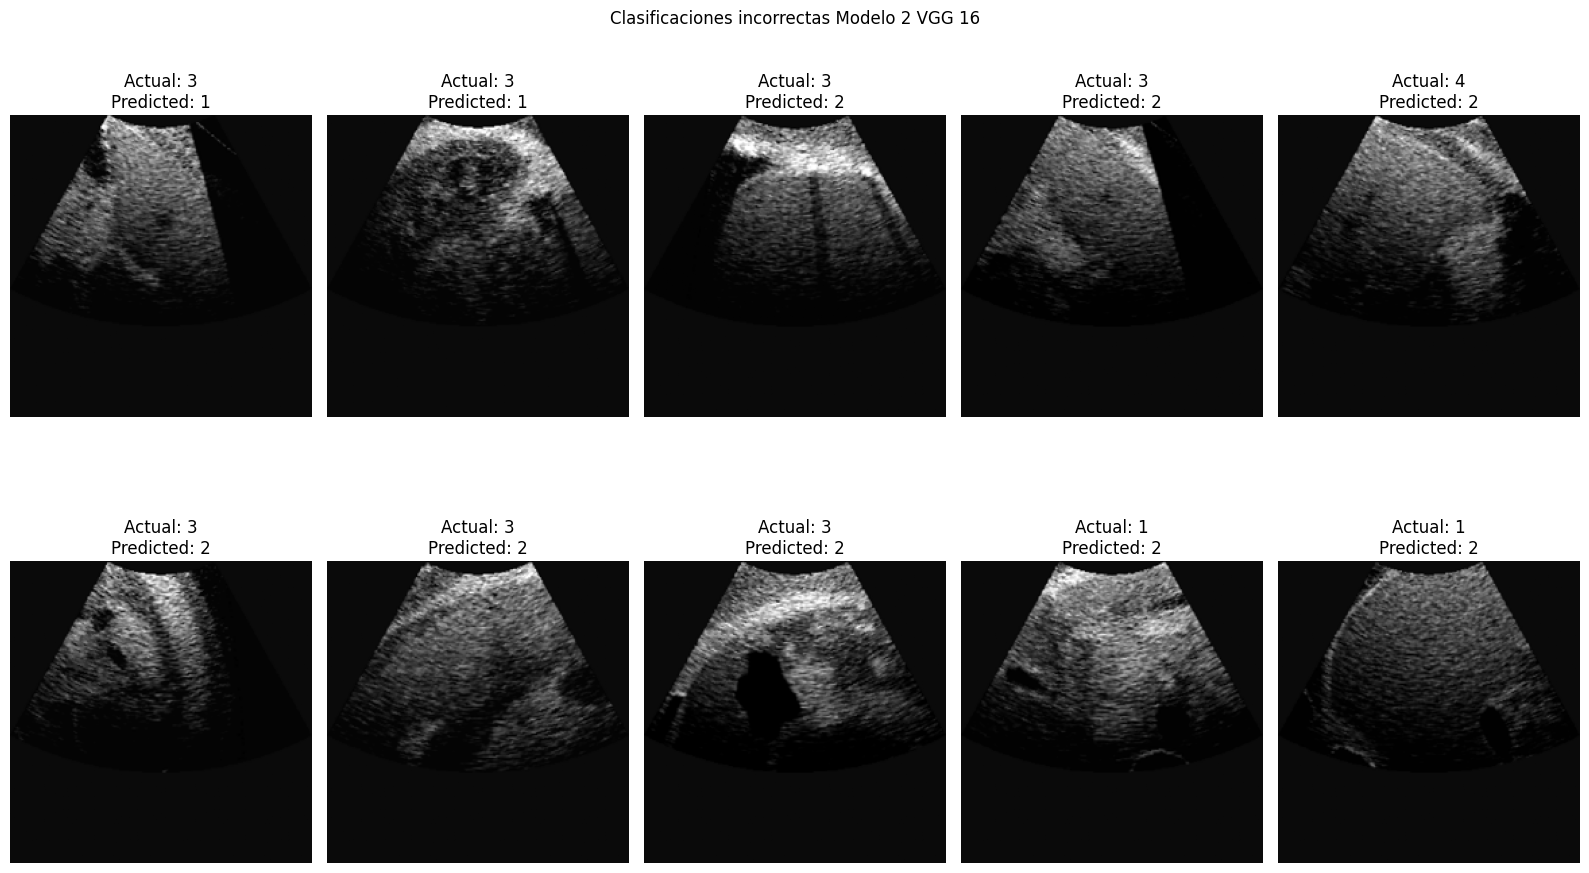

In [ ]:
plot_clasification_examples(example_bad_idx)
plt.suptitle("Clasificaciones incorrectas Modelo 2 VGG 16")
plt.show()

### Resultados del Modelo VGG 16 con Fine Tuning

* El modelo alcanza un 90% de precisión en el conjunto de prueba. Este valor es sólido y está alineado con las expectativas de un modelo de transfer learning en un entorno médico.

* Estabilidad: Los promedios macro (0.87) y ponderado (0.91) son muy cercanos, indicando que el modelo tiene un buen rendimiento generalizado en todas las clases, sin estar tan sesgado por las clases grandes.

* Generalización: La diferencia de precisión entre el entrenamiento (≈0.95) y la prueba (≈0.92) es de solo 3 puntos porcentuales, lo que indica que el aprendió a generalizar y no está sobreajustado.

**Análisis por clases**

* F0 (Ausencia cirrosis): El modelo tiene un desempeño perfecto en está clase, lo que indica que nunca diagnostica erróneamente a un paciente sano, lo cual minimiza los estudios invasivos innecesarios.

* F2 (Intermedia): El Recall (0.93) es alto, lo que significa que el modelo identifica la mayoría de los casos reales de F2. Sin embargo, la Precisión (0.64) es baja, lo que indica que 36% de las veces que el modelo predice F2, se equivoca (son falsos positivos).

* F4 (Cirrosis): Alta capacidad para detectar el estadio terminal (0.95 f1-score).

## Conclusiones

1. Se valida la hipótesis de que el Transfer Learning es el enfoque metodológico superior para la clasificación de fibrosis hepática a partir de imágenes ecográficas con datasets limitados.
2. El modelo demuestra una capacidad prometedora para la detección temprana de fibrosis (F2 y F3). El alto recall en F2 (0.93) indica que la herramienta puede identificar a casi 9 de cada 10 pacientes en riesgo, cumpliendo con el objetivo de identificación oportuna.
3. La baja precisión en F2 (0.64) sugiere que el modelo todavía tiene dificultades para distinguir las diferencias sutiles entre los estadios intermedios.




## -----------------------------------------------------------------------------

## Modelo 3: Resnet 50 con Fine tuning

### Preparación imagenes

In [ ]:
# Carga de imagenes y etiquetas
image_size = (224, 224)  # reconfigurar el tamaño de las imagenes a 224x224
X_train, y_train, class_indices = load_images_and_labels_from_dataframe(train_data, image_size=image_size)
X_val, y_val, _ = load_images_and_labels_from_dataframe(val_data, image_size=image_size)
X_test, y_test, _ = load_images_and_labels_from_dataframe(test_data, image_size=image_size)

# No se normalizan las imagenes, ResNet tiene una función de preprocesamiento asociada a la arquitectura

# Número de clases e indices respectivos
num_classes = len(class_indices)
print(f"Clases: {class_indices}")
print(f"Número de clases: {num_classes}")

Clases: {'F0': 0, 'F1': 1, 'F2': 2, 'F3': 3, 'F4': 4}
Número de clases: 5


### Definición arquitectura

In [ ]:
conv_base_resnet = ResNet50(weights='imagenet',
                            include_top=False,
                            input_shape=(224, 224, 3))

In [ ]:
# Congelar capas
conv_base_resnet.trainable = False

# Descongelar ciertas capas (ultimas 20)
for layer in conv_base_resnet.layers[-20:]:
    layer.trainable = True

print("Capas entrenables en ResNet50:")
for layer in conv_base_resnet.layers:
    print(f"{layer.name}: {'Entrenable' if layer.trainable else ''}")


Capas entrenables en ResNet50:
input_layer_7: 
conv1_pad: 
conv1_conv: 
conv1_bn: 
conv1_relu: 
pool1_pad: 
pool1_pool: 
conv2_block1_1_conv: 
conv2_block1_1_bn: 
conv2_block1_1_relu: 
conv2_block1_2_conv: 
conv2_block1_2_bn: 
conv2_block1_2_relu: 
conv2_block1_0_conv: 
conv2_block1_3_conv: 
conv2_block1_0_bn: 
conv2_block1_3_bn: 
conv2_block1_add: 
conv2_block1_out: 
conv2_block2_1_conv: 
conv2_block2_1_bn: 
conv2_block2_1_relu: 
conv2_block2_2_conv: 
conv2_block2_2_bn: 
conv2_block2_2_relu: 
conv2_block2_3_conv: 
conv2_block2_3_bn: 
conv2_block2_add: 
conv2_block2_out: 
conv2_block3_1_conv: 
conv2_block3_1_bn: 
conv2_block3_1_relu: 
conv2_block3_2_conv: 
conv2_block3_2_bn: 
conv2_block3_2_relu: 
conv2_block3_3_conv: 
conv2_block3_3_bn: 
conv2_block3_add: 
conv2_block3_out: 
conv3_block1_1_conv: 
conv3_block1_1_bn: 
conv3_block1_1_relu: 
conv3_block1_2_conv: 
conv3_block1_2_bn: 
conv3_block1_2_relu: 
conv3_block1_0_conv: 
conv3_block1_3_conv: 
conv3_block1_0_bn: 
conv3_block1_3_bn: 
c

In [ ]:
x = conv_base_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', name='dense_512')(x)
x = Dropout(0.3)(x)
predictions = Dense(5, activation='softmax', name='predictions')(x)

model_resnet = Model(inputs=conv_base_resnet.input, outputs=predictions)

In [ ]:

# Compile the model with RMSprop optimizer
model_resnet.compile(
    optimizer=optimizers.RMSprop(learning_rate=1e-4),  # Tasa pequeña de aprendizaje para fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  #
)

# Arquitectura y resumen del modelo
model_resnet.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_7[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

### Entrenamiento del modelo

In [ ]:
# Definir el callback Early stopping
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=4,
    restore_best_weights=True
)


In [ ]:
history_resnet = model_resnet.fit(
    X_train, y_train,
    epochs=50,
    batch_size=200,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 34s 990ms/step - accuracy: 0.5511 - loss: 1.1198 - val_accuracy: 0.4684 - val_loss: 1.4350
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.8676 - loss: 0.3702 - val_accuracy: 0.7115 - val_loss: 0.8907
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 315ms/step - accuracy: 0.9640 - loss: 0.1279 - val_accuracy: 0.7362 - val_loss: 0.9831
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 314ms/step - accuracy: 0.9878 - loss: 0.0502 - val_accuracy: 0.7875 - val_loss: 0.7950
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 307ms/step - accuracy: 0.9996 - loss: 0.0092 - val_accuracy: 0.7856 - val_loss: 0.8264
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 312ms/step - accuracy: 0.9831 - loss: 0.0607 - val_accuracy: 0.8913 - val_loss: 0.4628
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 305ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.8824 - val_loss: 0.5250
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 309ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0

### Precisión y Perdida

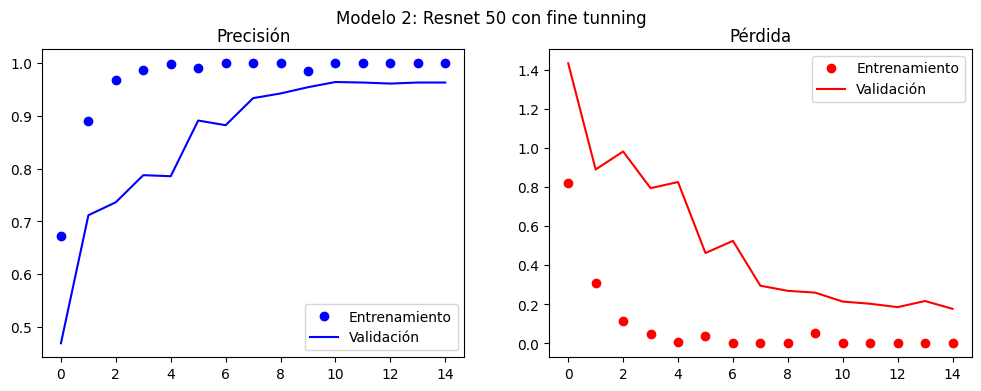

In [ ]:
acc_vgg = history_resnet.history['accuracy']
val_acc_vgg = history_resnet.history['val_accuracy']
loss_vgg = history_resnet.history['loss']
val_loss_vgg = history_resnet.history['val_loss']
epochs = range(len(acc_vgg))

plt.figure(figsize=(12, 4))
plt.suptitle("Modelo 2: Resnet 50 con fine tunning")
plt.subplot(1, 2, 1)
plt.plot(epochs, acc_vgg, 'bo', label='Entrenamiento')
plt.plot(epochs, val_acc_vgg, 'b', label="Validación")
plt.title('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vgg, 'ro', label='Entrenamiento')
plt.plot(epochs, val_loss_vgg, 'r', label='Validación')
plt.title('Pérdida')
plt.legend()

plt.show()

### Resultados (Training set)

In [ ]:
y_pred_train = model_resnet.predict(X_train)
y_pred_train = np.argmax(y_pred_train, axis=1)

print(classification_report(y_train, y_pred))

127/127 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1353
           1       1.00      1.00      1.00       551
           2       1.00      1.00      1.00       507
           3       1.00      1.00      1.00       549
           4       1.00      1.00      1.00      1086

    accuracy                           1.00      4046
   macro avg       1.00      1.00      1.00      4046
weighted avg       1.00      1.00      1.00      4046



### Resultados (testing set)

In [ ]:
y_pred = model_resnet.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_labels))

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       423
           1       0.99      0.91      0.95       172
           2       0.89      0.93      0.91       159
           3       0.95      0.91      0.93       171
           4       0.97      1.00      0.99       340

    accuracy                           0.97      1265
   macro avg       0.96      0.95      0.95      1265
weighted avg       0.97      0.97      0.97      1265



#### Matriz de confusión

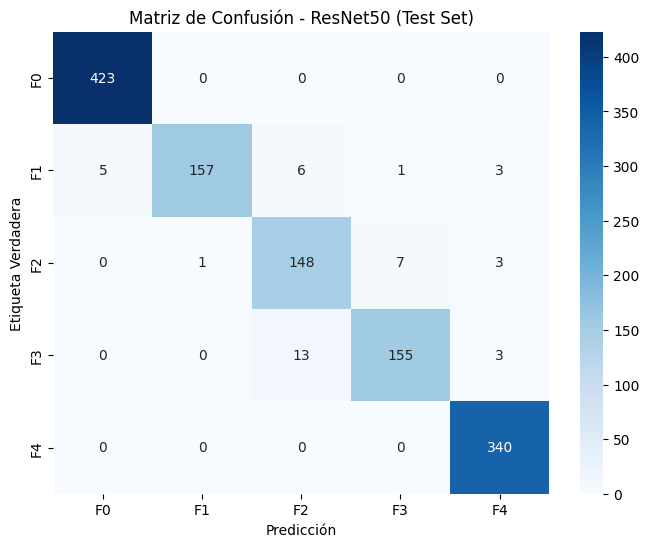

In [ ]:
#Generar la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_labels)

#Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión - ResNet50 (Test Set)')
plt.show()

### Ejemplos de clasificación

In [ ]:
good_idx = np.where(y_pred_labels == y_test)[0]
bad_idx = np.where(y_pred_labels != y_test)[0]

print(f"Good predictions: {len(good_idx)}")
print(f"Bad predictions: {len(bad_idx)}")

num_examples = 10
example_good_idx = np.random.choice(good_idx, size=num_examples, replace=False)
example_bad_idx = np.random.choice(bad_idx, size=num_examples, replace=False)

Good predictions: 1223
Bad predictions: 42


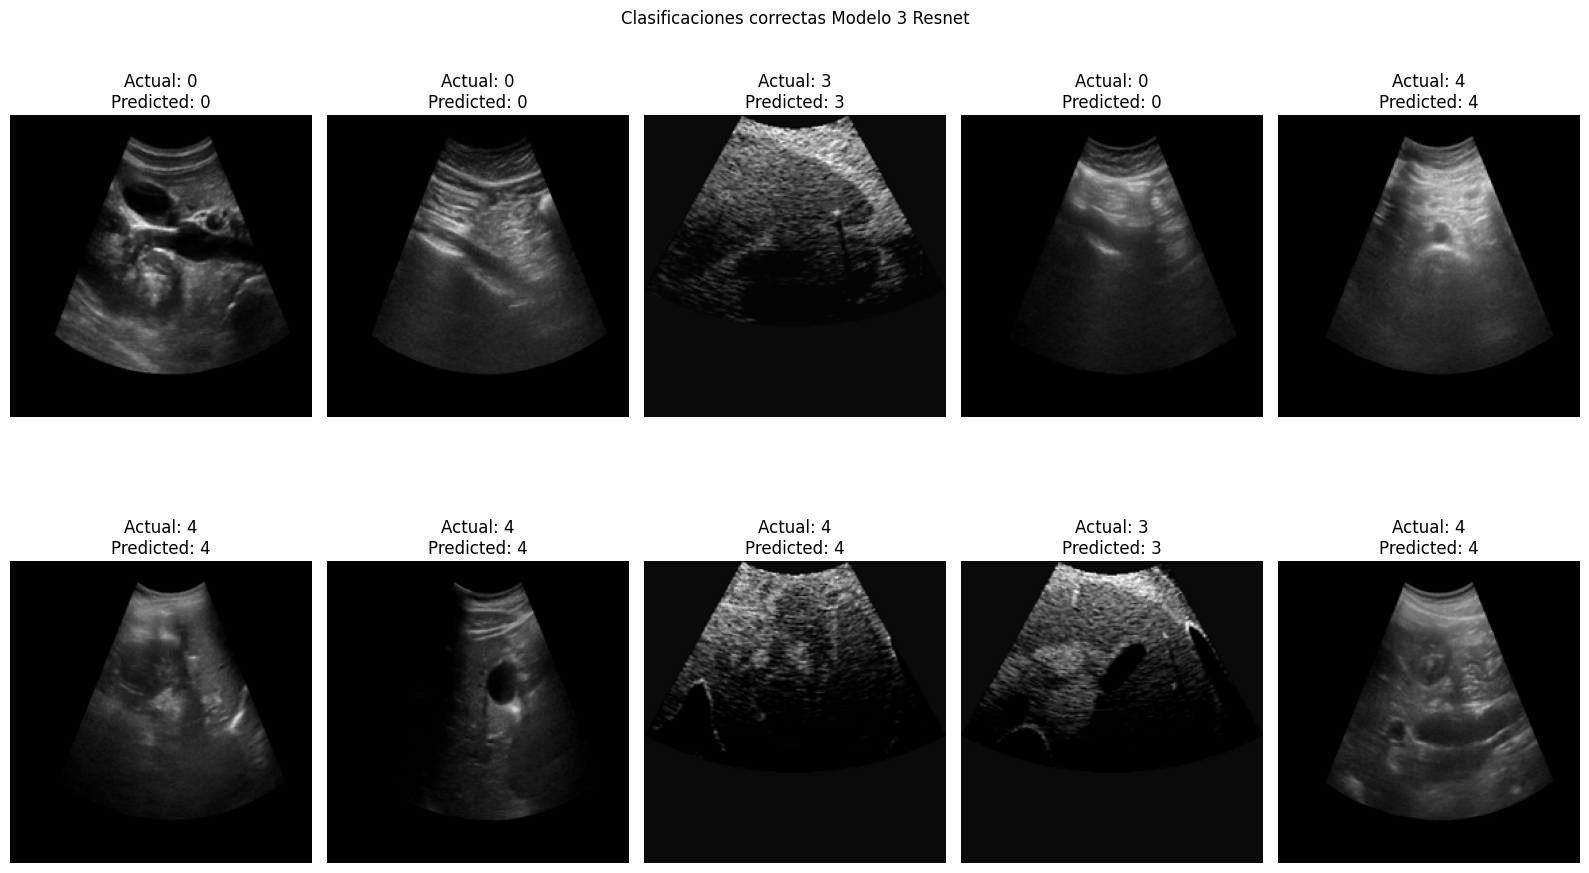

In [ ]:
plot_clasification_examples(example_good_idx)
plt.suptitle("Clasificaciones correctas Modelo 3 Resnet")
plt.show()

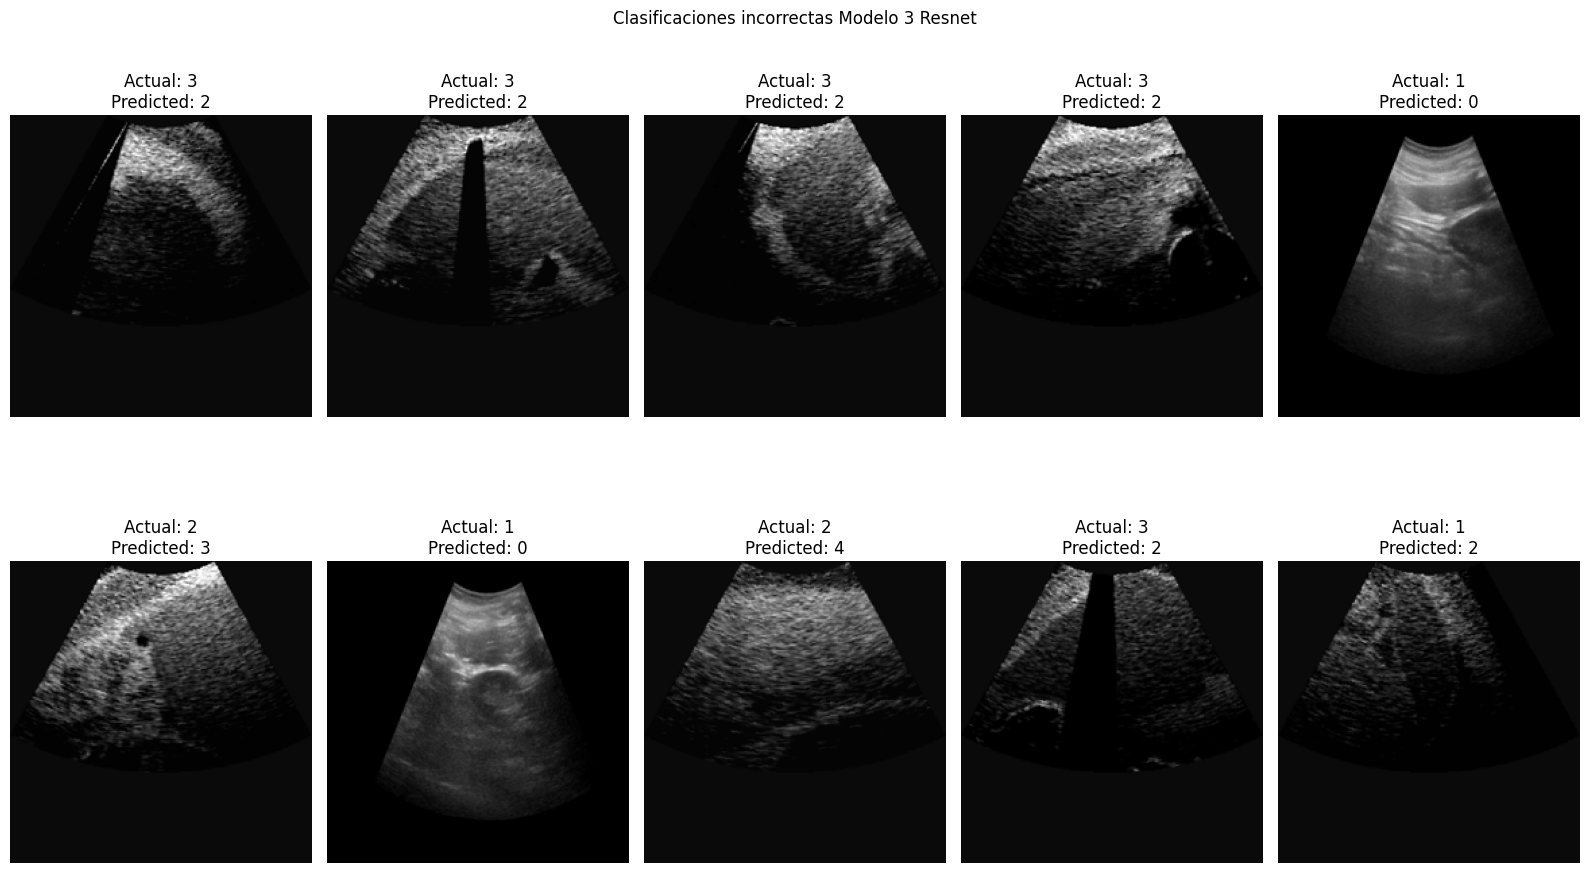

In [ ]:
plot_clasification_examples(example_bad_idx)
plt.suptitle("Clasificaciones incorrectas Modelo 3 Resnet")
plt.show()

### Resultados del Modelo ResNet con Fine Tuning

* El modelo logra un rendimiento del 97% en el conjunto de prueba.

* La precisión en el test set es de 0.97, mientras que en el training set es de 1.00. Esta diferencia de 3 puntos porcentuales es mínima, lo que demuestra una generalización del conocimiento de ResNet al dominio de la ecografía hepática.

**Análisis de clases**

* Las clases minoritarias, como F2, tienen un F1-Score de 0.91 (Precision 0.89, Recall 0.93). Esto significa que el modelo es altamente fiable para la detección de fibrosis intermedia, resolviendo el problema de la baja precisión que se veía en el modelo VGG16 (0.67).

## Conclusiones

1. El desarrollo de un modelo basado en ResNet50 con Transfer Learning alcanzó un rendimiento de 97% de precisión, superando el desempeño de métodos no invasivos actuales y estableciendo un nuevo umbral de referencia para el diagnóstico automatizado de fibrosis hepática.

2. La alta precisión en la detección de estadios intermedios (F2,F3) y avanzados (F4) con un F1-Score de 0.91 para F2, esto valida la propuesta de valor del proyecto: proporcionar una herramienta accesible, objetiva y automatizada que pueda discriminar con alta fiabilidad los pacientes que requieren intervención urgente de aquellos que no.

3. Para la aplicación de Deep Learning en la clasificación de imágenes médicas con datasets limitados, el Transfer Learning con preprocesamiento específico de la arquitectura es el enfoque metodológico más robusto y eficaz.


## ----------------------------------------------------------------------------

# **Modelo para despliegue**

## Guardado de modelo ResNet

In [ ]:
model_resnet.save('resnet_model.keras')
print("model_resnet saved to resnet_model.keras")

model_resnet saved to resnet_model.keras


## Carga del modelo ResNet guardado

In [ ]:
# Carga el modelo
model = load_model('resnet_model.keras', compile=False)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,639,365 (93.99 MB)

 Trainable params: 9,982,981 (38.08 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

## Hacer predicciones con el modelo ResNet cargado

In [ ]:
predictions_loaded_model = model.predict(X_val)
print("First 5 predictions from the loaded model:\n", predictions_loaded_model[:5])

32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step
First 5 predictions from the loaded model:
 [[9.9999487e-01 1.3602613e-06 4.9091727e-07 3.2644490e-07 3.0185249e-06]
 [8.5680017e-07 3.3289307e-06 7.7458581e-06 2.4740763e-07 9.9998784e-01]
 [2.1236192e-04 9.9947619e-01 5.3018230e-05 1.1492648e-04 1.4339942e-04]
 [9.9999094e-01 3.8615613e-06 5.5792799e-07 7.4282752e-07 3.8714993e-06]
 [9.9999630e-01 1.1094634e-07 1.4019597e-07 2.3039777e-07 3.1967636e-06]]


In [ ]:
print(model.inputs)
print(model.outputs)

[<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, ragged=False, name=input_layer_5>]
[<KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1493>]


## Resumen

*   El `modelo ResNet` se guardó correctamente en `resnet_model.keras`.
*   El modelo guardado se cargó correctamente desde `resnet_model.keras` a una nueva variable, `model`, con su arquitectura, incluyendo la base `resnet50`, la agrupación y las capas densas, y el recuento de parámetros verificado mediante `summary()`.
*   El `model` se utilizó correctamente para generar predicciones en el conjunto de datos de validación (`X_val`), lo que confirma su funcionalidad.

### Siguientes pasos

*   El guardado, la carga y la predicción exitosa demuestran que el modelo ResNet está listo para su implementación.
*   Los pasos posteriores incluyen la integración del modelo cargado en un entorno de producción para la inferencia en tiempo real.

In [ ]:
!git clone https://github.com/maperezp/Proyecto-DL-Grupo4.git

fatal: destination path 'Proyecto-DL-Grupo4' already exists and is not an empty directory.
